🚀 Starting Final Evaluation on cpu...
✅ Found 152 test videos.
✅ Weights loaded successfully.

🔍 Scanning Test Set...


100%|██████████| 38/38 [06:06<00:00,  9.64s/it]



🏆 TEST ACCURACY: 96.71%
--------------------------------------------------
              precision    recall  f1-score   support

        Real       0.95      0.99      0.97        74
        Fake       0.99      0.95      0.97        78

    accuracy                           0.97       152
   macro avg       0.97      0.97      0.97       152
weighted avg       0.97      0.97      0.97       152



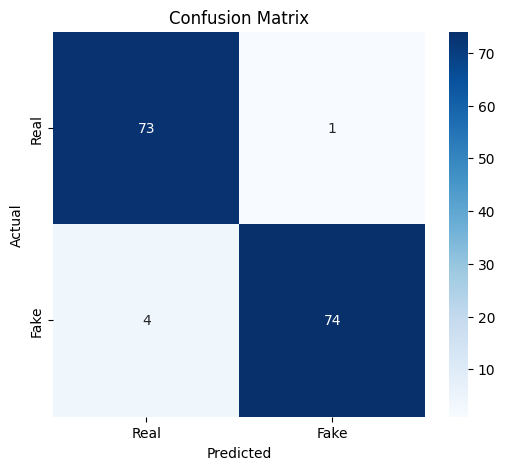


⚠️ The model failed on these 5 videos:
                  Video  True  Pred
     Real_762_id23_0000     0     1
Fake_794_id49_id55_0008     1     0
Fake_795_id25_id22_0002     1     0
Fake_751_id44_id43_0000     1     0
Fake_772_id40_id47_0001     1     0


In [8]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import cv2
import numpy as np
import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 🔧 CONFIGURATION
# ==========================================
TEST_DIR = "/kaggle/input/ddataset/Deepfake_Active_Dataset/test"
MODEL_PATH = "/kaggle/input/ddataset/efficientnet_b3_lstm_active.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LENGTH = 20
IMG_SIZE = 224

print(f"🚀 Starting Final Evaluation on {DEVICE}...")

# ==========================================
# 1. DEFINE MODEL (Must match Training Config!)
# ==========================================
class EfficientNetLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetLSTM, self).__init__()
        # Backbone
        backbone = models.efficientnet_b3(weights=None)
        backbone.classifier = nn.Identity()
        self.feature_extractor = backbone
        
        # LSTM Settings (Matches your training code)
        self.lstm = nn.LSTM(
            input_size=1536, 
            hidden_size=512,    # HIDDEN_DIM from training
            num_layers=1, 
            batch_first=True, 
            bidirectional=True  # BIDIRECTIONAL from training
        )
        
        self.dropout = nn.Dropout(0.4)
        
        # FC Input = 512 * 2 (because bidirectional)
        self.fc = nn.Linear(512 * 2, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        c_in = x.view(batch_size * seq_len, c, h, w)
        features = self.feature_extractor(c_in)
        features = features.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(features)
        last_out = lstm_out[:, -1, :] 
        out = self.dropout(last_out)
        return self.fc(out)

# ==========================================
# 2. LOAD DATASET
# ==========================================
class DeepfakeTestDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Scan for Real/Fake folders
        for label, class_name in enumerate(["Real", "Fake"]):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir): continue
            
            folders = [f.path for f in os.scandir(class_dir) if f.is_dir()]
            for folder in folders:
                if len(os.listdir(folder)) > 0:
                    self.samples.append((folder, label))
                    
        print(f"✅ Found {len(self.samples)} test videos.")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        frames = sorted(glob.glob(os.path.join(path, "*.jpg")), 
                        key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))
        
        # Sampling Strategy (Uniform 20)
        if len(frames) >= SEQ_LENGTH:
            indices = np.linspace(0, len(frames)-1, SEQ_LENGTH, dtype=int)
            selected = [frames[i] for i in indices]
        else:
            selected = frames + [frames[-1]] * (SEQ_LENGTH - len(frames))
            
        images = []
        for p in selected:
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.transform(transforms.ToPILImage()(img))
            images.append(img)
            
        return torch.stack(images), label, os.path.basename(path)

# ==========================================
# 3. RUN EVALUATION
# ==========================================
def evaluate():
    # Load Data
    test_ds = DeepfakeTestDataset(TEST_DIR)
    if len(test_ds) == 0:
        print("❌ Error: No test data found. Check path.")
        return
        
    loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)
    
    # Load Model
    model = EfficientNetLSTM().to(DEVICE)
    try:
        # Load weights (handle if saved as full dict or state_dict)
        checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
        state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
        model.load_state_dict(state_dict)
        print("✅ Weights loaded successfully.")
    except Exception as e:
        print(f"❌ Failed to load weights: {e}")
        return

    model.eval()
    
    y_true, y_pred = [], []
    video_names = []
    
    print("\n🔍 Scanning Test Set...")
    with torch.no_grad():
        for inputs, labels, v_names in tqdm(loader):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            video_names.extend(v_names)
            
    # --- REPORTING ---
    acc = accuracy_score(y_true, y_pred)
    print(f"\n🏆 TEST ACCURACY: {acc*100:.2f}%")
    print("-" * 50)
    print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))
    
    # Confusion Matrix Plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Show Failures
    results = pd.DataFrame({"Video": video_names, "True": y_true, "Pred": y_pred})
    failures = results[results["True"] != results["Pred"]]
    
    if len(failures) > 0:
        print(f"\n⚠️ The model failed on these {len(failures)} videos:")
        print(failures.head(10).to_string(index=False))
    else:
        print("\n🎉 PERFECT SCORE! No failures.")

if __name__ == "__main__":
    evaluate()